In [24]:
# IMPORT LIBRARIES

from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014, McMillan17
import matplotlib.pyplot as plt
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
from scipy.fft import *
from scipy import interpolate, optimize
from astropy.io import fits
from astropy.table import Table
import csv
from galpy.potential import plotRotcurve

# AUXILIARY FUNCTIONS

def load_sofue(rmin, rmax):
    R = []
    vrot = []
    vrotmax = []
    vrotmin = []
    with open('vrot_sofue.csv') as f:
        reader = csv.reader(f)
        print(next(reader))
        for l in reader:
            if float(l[0]) < rmin or float(l[0]) > rmax:
                continue
            R.append(float(l[0]))
            vrot.append(float(l[1]))
            vrotmax.append(float(l[1]) + float(l[2]))
            vrotmin.append(float(l[1]) - float(l[2]))
    R, vr, vrotmax, vrotmin = (np.array(i) for i in (R, vrot, vrotmax, vrotmin))
    return R, vr, vrotmax, vrotmin

def load_galpy(curve, rmin, rmax):
    rc = plotRotcurve(curve, ro=R0, vo=V0);
    R = np.array(rc[0].get_xdata())
    Vc = np.array(rc[0].get_ydata())

    relR = (R >= rmin) & (R <= rmax)
    R = R[relR]
    Vc = Vc[relR]
    return R, Vc
    

['R', 'vrot', 'stdev']
-0.030006426637438157


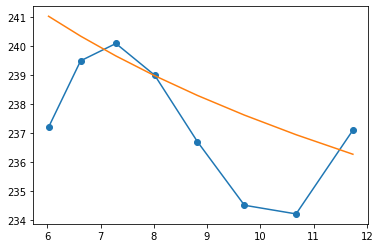

In [6]:
# Find optimal n for Sofue 2020 rotation curve

V0 = 239
R0 = 8
def vfun(R, n):
    return V0 * (R/R0)**n

rr, vr, _, _ = load_sofue(5.5,12)

vrinterp = interpolate.interp1d(rr, vr)
optn = optimize.curve_fit(vfun, rr, vr)[0][0]
print(optn)

plt.plot(rr,vr)
plt.scatter(rr,vr)
plt.plot(rr, vfun(rr,optn))

-0.06431559252273432


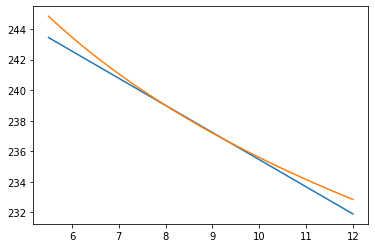

In [8]:
# Find optimal n for Eilers 2019 rotation curve

rr2 = np.linspace(5.5,12,100)
vrn = (V0/229)*(229-1.7*(rr2-R0))
plt.plot(rr2,vrn)


def vfun(R, n):
    return V0 * (R/R0)**n

optn = optimize.curve_fit(vfun, rr2, vrn)[0][0]
print(optn)

plt.plot(rr2, vfun(rr2,optn))

[-0.00103636]


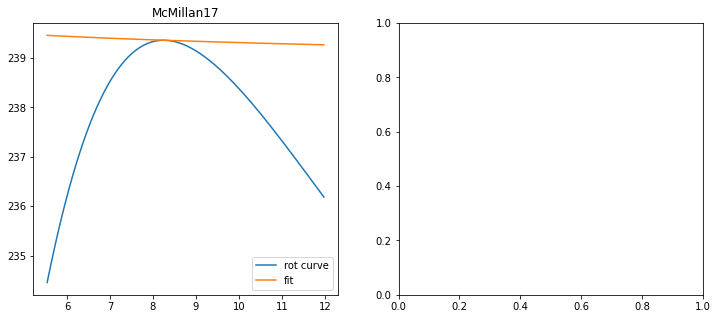

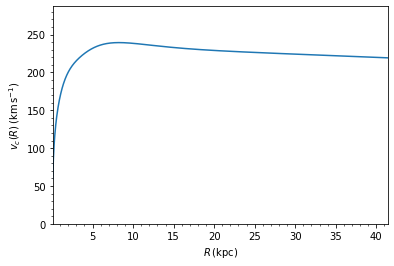

In [19]:
# Find optimal n for McMillan 2017 rotation curve

R0=8.277
V0=251.5-12.24

fig, ax = plt.subplots(1, 2, figsize=(12,5))

from galpy.potential.mwpotentials import MWPotential2014, McMillan17, Irrgang13I
R, Vc = load_galpy(McMillan17, 5.5, 12)

ax[0].plot(R, Vc, label='rot curve')
interpv = interpolate.interp1d(R,Vc)

def trc(r, n, ro, vo):
    return vo * (r/ro)**n
fitf = lambda R, n: trc(R, n, ro=R0, vo=interpv(R0))

optn = optimize.curve_fit(fitf, R, Vc)[0]
ax[0].plot(R, trc(R,optn,R0,interpv(R0)), label='fit')
ax[0].set_title('McMillan17')
ax[0].legend()
print(optn)


[-0.09552168]


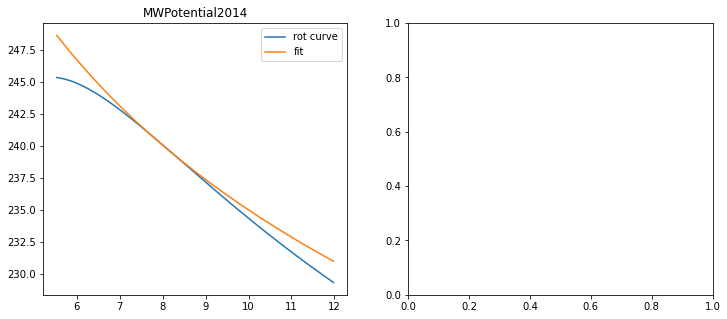

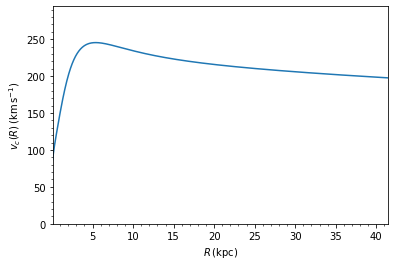

In [25]:
# Find optimal n for MWPotential2014 rotation curve

R0=8.277
V0=251.5-12.24

fig, ax = plt.subplots(1, 2, figsize=(12,5))

from galpy.potential.mwpotentials import MWPotential2014, McMillan17, Irrgang13I
R, Vc = load_galpy(MWPotential2014, 5.5, 12)

ax[0].plot(R, Vc, label='rot curve')
interpv = interpolate.interp1d(R,Vc)

def trc(r, n, ro, vo):
    return vo * (r/ro)**n
fitf = lambda R, n: trc(R, n, ro=R0, vo=interpv(R0))

optn = optimize.curve_fit(fitf, R, Vc)[0]
ax[0].plot(R, trc(R,optn,R0,interpv(R0)), label='fit')
ax[0].set_title('MWPotential2014')
ax[0].legend()
print(optn)


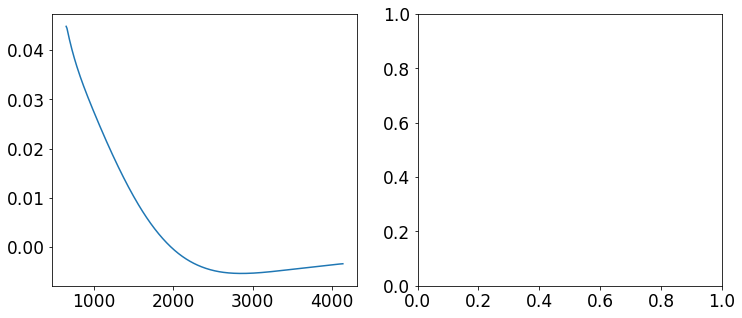

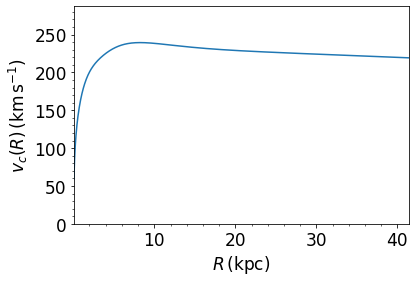

In [34]:
# Calculate n (locally) directly from rotation curve

R0=8.277
V0=251.5-12.24

fig, ax = plt.subplots(1, 2, figsize=(12,5))

from galpy.potential.mwpotentials import MWPotential2014, McMillan17, Irrgang13I
R, Vc = load_galpy(McMillan17, 3, 18)
mcm_Lz = Vc * R
mcm_n = np.gradient(Vc)/np.gradient(mcm_Lz)
ax[0].plot(mcm_Lz, mcm_n)


0.0006666666666666666
2136.752136752085


Text(0.5, 0, 'Frequency of $V_R/L_z$ in $L_Z^{\\frac{n-1}{n+1}}$')

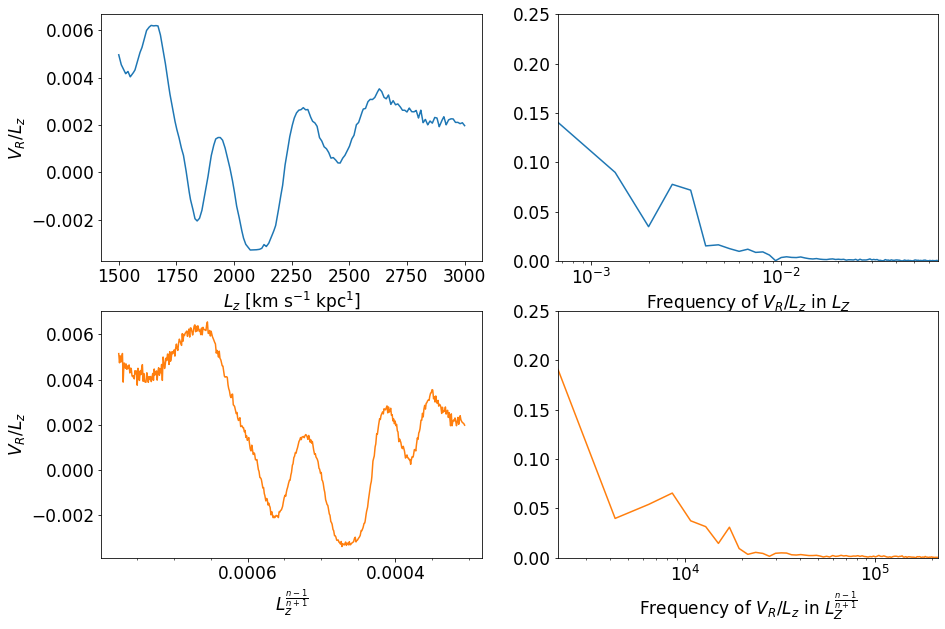

In [36]:
# Plot the untransformed and transformed (with Lz**((n+1)/(n-1)), with the n's calculated in previous cell)
# Gaia data and the corresponding Fourier transforms

def load_data(xmin=1500, xmax=3500, phi_range=0.4, new=False):
    path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
    oo = Table.read(path, format='fits')

    VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
    Lz=-oo['Vphi']*oo['R']
    phi=-np.deg2rad(phi)
    Vphi=-Vphi

    indphi = abs(phi) < phi_range
    x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
    indphi=(Lz>xmin)&(Lz<xmax)
    x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
    return x,y,VR,Vphi,R,Lz,phi

plt.rcParams['font.size'] = 17

XMIN=1500
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,2,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
cplt = ax[0][0]
cplt.plot(xpol, ypol, c='C0')
cplt.set_aspect('auto')
cplt.set_xlabel(r'$L_z$ [km s$^{-1}$ kpc$^{1}$]')
cplt.set_ylabel(r'$V_R/L_z$')
#cplt.xaxis.label.set_color('C0')
#cplt.spines['bottom'].set_color('C0')
#cplt.tick_params(axis='x', colors='C0')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
print(1/xfr[np.argmax(np.abs(yf))])
cplt = ax[0][1]
cplt.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C0')
cplt.set_xlim(1/max(xfr), 1/xfr[100])
cplt.set_xscale('log')
cplt.set_aspect('auto')
cplt.set_xlabel('Frequency of $V_R/L_z$ in $L_Z$')
cplt.set_ylim(0,0.25)


interpn = interpolate.interp1d(mcm_Lz, mcm_n)
n = interpn(Lz)
Lzl = Lz**((n-1)/(n+1))
nx, ny = smooth_bins(Lzl, VR/Lz, np.min(Lzl), np.max(Lzl), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
axb = ax[1][0]
axb.plot(xpol, ypol, c='C1')
axb.set_xlabel(r'$L_z^\frac{n-1}{n+1}$')
axb.set_ylabel(r'$V_R/L_z$')
#axb.spines['top'].set_color('C1')
#axb.tick_params(axis='x', colors='C1')
#axb.xaxis.label.set_color('C1')
axb.set_xlim(axb.get_xlim()[::-1])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
axb.xaxis.set_minor_locator(AutoMinorLocator())
axb.locator_params(axis='x', nbins=4)


ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
axb = ax[1][1]
axb.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C1')
print(1/xfr[np.argmax(np.abs(yf))])
axb.set_xlim(1/max(xfr), 1/xfr[100])
axb.set_ylim(0,0.25)
axb.set_xscale('log')
axb.set_aspect('auto')
axb.set_xlabel(r'Frequency of $V_R/L_z$ in $L_Z^{\frac{n-1}{n+1}}$')
